In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_ind

In [2]:
data = pd.read_csv("figure1_mean.csv")

In [3]:
data.columns = data.columns.str.strip()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.strip()

data.columns = ['Subset Ratio', 'Model', 'NMI', 'ARI', 'Isolated\nLabel Score',
       'Biological\nConservation', 'Modality\nASW', 'FOSCTTM',
       'Label\nTransfer F1', 'Modality\nAlignment', 'RNA\nPearson\'s r',
       'ADT\nPearson\'s r', 'Feature\nImputation', 'Comprehensive\nScore']

metric_groups = {
    "Biological\nConservation": ['NMI', 'ARI', 'Isolated\nLabel Score', 'Biological\nConservation'],
    "Modality\nAlignment": ['Modality\nASW', 'FOSCTTM', 'Label\nTransfer F1', 'Modality\nAlignment'],
    "Feature\nImputation": ['RNA\nPearson\'s r', 'ADT\nPearson\'s r', 'Feature\nImputation'],
    "Comprehensive\nScore": ['Comprehensive\nScore']
}

cmap_list = [['#F3A69F', '#FAE4E3'], ['#89BE88', '#CEE2CE'], ['#92B4DB','#D7E4F3'], ['#F3B339', '#FBE7C1']]
batch_list = ['10%', '20%', '50%', '100%']
model_order = ['Baseline', 'MINERVA']

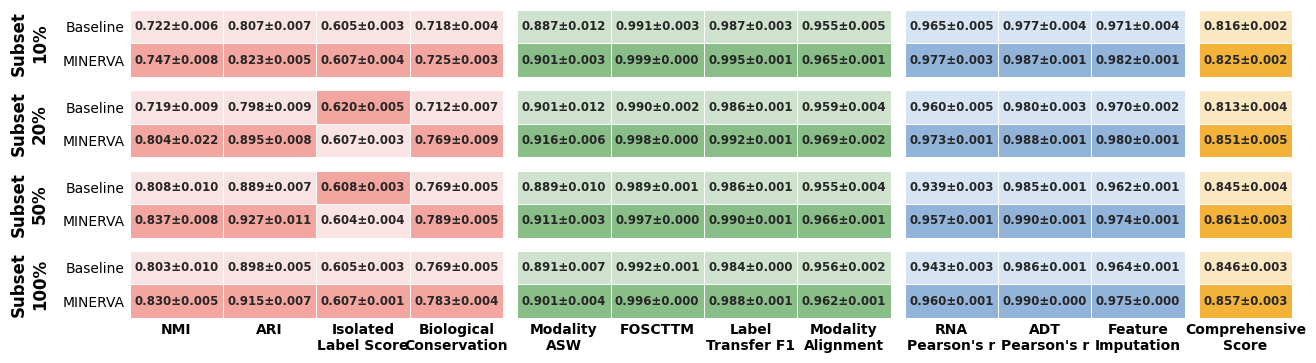

In [4]:
fig, axes = plt.subplots(4, 4, sharey='row', gridspec_kw={'width_ratios':[4, 4, 3, 1]}, figsize=(15, 4))
plt.subplots_adjust(wspace = 0.05, hspace = 0.2)

for col_idx, (group_name, metrics) in enumerate(metric_groups.items()):
    current_cmap = ListedColormap(cmap_list[col_idx])
    
    for row_idx, sampling_ratio in enumerate(batch_list):
        ax = axes[row_idx, col_idx]
        
        _data = data[data['Subset Ratio'] == sampling_ratio].copy()
        
        for metric in metrics:
            _data[metric] = pd.to_numeric(_data[metric], errors='coerce')
        
        grouped = _data.groupby('Model')
        data_mean = grouped[metrics].mean().reindex(model_order)
        data_std = grouped[metrics].std().reindex(model_order)

        data_ranked = data_mean.rank(axis=0, ascending=False, method='min').astype(int)

        annot_labels = pd.DataFrame(index=data_mean.index, columns=data_mean.columns)
        for model in data_mean.index:
            for metric in data_mean.columns:
                mean_val = data_mean.loc[model, metric]
                std_val = data_std.loc[model, metric]
                annot_labels.loc[model, metric] = f"{mean_val:.3f}±{std_val:.3f}"

        xticklabels = row_idx == len(batch_list) - 1
        
        sns.heatmap(data_ranked, annot=annot_labels, fmt='', cmap=current_cmap, ax=ax,
                    annot_kws={"fontsize": 8.5, "fontweight": 'bold'},
                    linewidths=0.5, linecolor='white', cbar=False, xticklabels=xticklabels)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, length=0) 
        ax.tick_params(axis='x', length=0)

        if col_idx == 0:
            ax.set_ylabel("Subset\n" + sampling_ratio, rotation=90, fontsize=12, fontweight='bold', labelpad=10)
        
        if xticklabels:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10, fontweight='bold')
plt.savefig('figure1_mean.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [5]:
metrics_all = data.columns[2:]
p_values_df = pd.DataFrame(index=batch_list, columns=metrics_all)

for ratio in batch_list:
    for metric in metrics_all:
        data[metric] = pd.to_numeric(data[metric], errors='coerce')
        
        ratio_data = data[data['Subset Ratio'] == ratio]
        
        minerva_scores = ratio_data[ratio_data['Model'] == 'MINERVA'][metric].dropna()
        baseline_scores = ratio_data[ratio_data['Model'] == 'Baseline'][metric].dropna()
        
        # 执行Welch's t-test
        # equal_var=False 表示不假设方差相等
        if len(minerva_scores) > 1 and len(baseline_scores) > 1:
            t_stat, p_val = ttest_ind(minerva_scores, baseline_scores, equal_var=False)
            p_values_df.loc[ratio, metric] = p_val
        else:
            p_values_df.loc[ratio, metric] = np.nan # 如果数据不足，则p值为NaN

# 3. 显示p值表格
print("P-values from Welch's t-test (MINERVA vs. Baseline):")
print(p_values_df.to_markdown(floatfmt=".4f"))


P-values from Welch's t-test (MINERVA vs. Baseline):
|      |    NMI |    ARI |      Isolated |     Biological |   Modality |   FOSCTTM |         Label |    Modality |           RNA |           ADT |      Feature |   Comprehensive |
|      |        |        |   Label Score |   Conservation |        ASW |           |   Transfer F1 |   Alignment |   Pearson's r |   Pearson's r |   Imputation |           Score |
|:-----|-------:|-------:|--------------:|---------------:|-----------:|----------:|--------------:|------------:|--------------:|--------------:|-------------:|----------------:|
| 10%  | 0.0000 | 0.0001 |        0.3867 |         0.0003 |     0.0038 |    0.0000 |        0.0000 |      0.0001 |        0.0000 |        0.0000 |       0.0000 |          0.0000 |
| 20%  | 0.0000 | 0.0000 |        0.0000 |         0.0000 |     0.0029 |    0.0000 |        0.0000 |      0.0000 |        0.0000 |        0.0000 |       0.0000 |          0.0000 |
| 50%  | 0.0000 | 0.0000 |        0.0147 |     

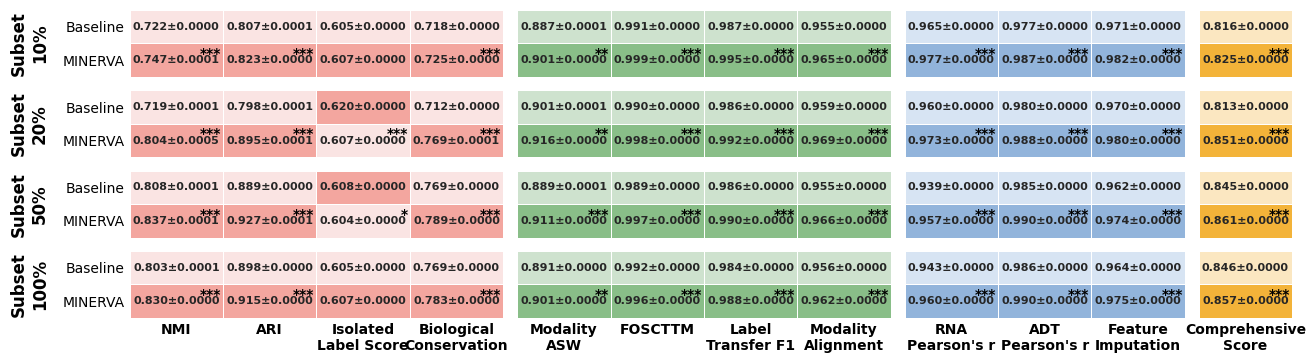

In [6]:
p_values_df.columns = data.columns[2:]

def get_significance_stars(p):
    if p is None or pd.isna(p):
        return ''
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


fig, axes = plt.subplots(4, 4, sharey='row', gridspec_kw={'width_ratios':[4, 4, 3, 1]}, figsize=(15, 4))
plt.subplots_adjust(wspace=0.05, hspace=0.2)

for col_idx, (group_name, metrics) in enumerate(metric_groups.items()):
    current_cmap = ListedColormap(cmap_list[col_idx])
    
    for row_idx, sampling_ratio in enumerate(batch_list):
        ax = axes[row_idx, col_idx]
        
        _data = data[data['Subset Ratio'] == sampling_ratio].copy()
        
        grouped = _data.groupby('Model')
        data_mean = grouped[metrics].mean().reindex(model_order)
        data_var = grouped[metrics].var().reindex(model_order)
        
        data_ranked = data_mean.rank(axis=0, ascending=False, method='min').astype(int)

        annot_labels = pd.DataFrame(index=data_mean.index, columns=data_mean.columns, dtype=str)
        for model in data_mean.index:
            for metric in data_mean.columns:
                mean_val = data_mean.loc[model, metric]
                var_val = data_var.loc[model, metric]
                annot_labels.loc[model, metric] = f"{mean_val:.3f}±{var_val:.4f}"
        xticklabels = row_idx == len(batch_list) - 1

        sns.heatmap(data_ranked, annot=annot_labels, fmt='', cmap=current_cmap, ax=ax,
                annot_kws={"fontsize": 8, "fontweight": 'bold'},
                linewidths=0.5, linecolor='white', cbar=False, xticklabels=xticklabels)

        for j, model in enumerate(data_mean.index):
            if model == 'MINERVA':
                for i, metric in enumerate(data_mean.columns):
                    p_val = p_values_df.loc[sampling_ratio, metric]
                    stars = get_significance_stars(p_val)
                        
                    if stars:
                        ax.text(i + 0.98, j + 0.1, stars, ha='right', va='top', color='black', fontsize=10, fontweight='bold')
                        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, length=0)
        ax.tick_params(axis='x', length=0)

        if col_idx == 0:
            ax.set_ylabel("Subset\n" + sampling_ratio, rotation=90, fontsize=12, fontweight='bold', labelpad=10)
        
        if xticklabels:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10, fontweight='bold')

plt.show()